In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from scipy.stats.stats import pearsonr
from scipy import signal

from scipy.signal import savgol_filter
from sklearn.metrics import pairwise_distances
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize
from functools import partial
from scipy.spatial.distance import correlation, euclidean, pdist, canberra
from sklearn.externals.joblib import Parallel, delayed, cpu_count
from sklearn.utils import gen_even_slices

from time import time, sleep
from roipoly import roipoly
#Shape of the data
height = 256
width = 256

import seaborn as sns
sns.set()

#28.815 and 86.5576
#90.14531424656546
TRUE_FRAMERATE = 28.815
IMAGING_FRAMERATE = 1/(34704.0/1e6)


In [99]:
#AUTOMATIC EXPERIMENT SELECTOR
directory = "/media/gu4n1n3/Data2/2_mice/20180312/"
experiment = "Experiment_2/"


import os
from os.path import join, getsize
subset_behaviour_file = ''
left_mouse_processed_file = ''
right_mouse_processed_file = ''
left_green_frame_file = ''
right_green_frame_file = ''
for root, dirs, files in os.walk(directory+experiment):
    if "Behaviour" in root:
        for file in files:
            if 'subset' in file and 'raw' in file:
                subset_behaviour_file = os.path.join(directory, experiment, root, file)
            
    else:
        for file in files:
            if '.mp4' not in file and 'png' not in file:
                if 'combined' in file and "raw" in file and 'upscaled' not in file:
                    if not 'gsr' in file:
                        if 'bandpass' in file:
                            combined_file = os.path.join(directory, experiment, root, file)
                elif 'LEFT_GREEN_processed' in file and '0.01-3.0Hz' in file:
                #elif 'LEFT_corrected_g_by_b' in file and '0.01-12.0Hz' in file:
                    left_mouse_processed_file = os.path.join(directory, experiment, root, file)
                #elif 'RIGHT_corrected_g_by_b' in file and '0.01-12.0Hz' in file:
                elif 'RIGHT_GREEN_processed' in file and '0.01-3.0Hz' in file:
                    right_mouse_processed_file = os.path.join(directory, experiment, root, file)
                elif 'LEFT_RAW_GREEN_FRAME' in file:
                    left_green_frame_file = os.path.join(directory, experiment, root, file)
                elif 'RIGHT_RAW_GREEN_FRAME' in file:
                    right_green_frame_file = os.path.join(directory, experiment, root, file)
             
date = left_mouse_processed_file.split("/")[5]
title = left_mouse_processed_file.split('/')[-1].split('.raw')[0]

print(date)
print(subset_behaviour_file)
print(left_mouse_processed_file)
print(right_mouse_processed_file)
print(left_green_frame_file)
print(right_green_frame_file)

20180312
/media/gu4n1n3/Data2/2_mice/20180312/Experiment_2/Behaviour/M803L_M804R_March-12_1524_experiment-2_wt_cage-mates_mouse_rail_together_12mm_subset_interpolated.raw
/media/gu4n1n3/Data2/2_mice/20180312/Experiment_2/LEFT_GREEN_processed__interp_dff0_bandpass0.01-3.0Hz_MM803L_March-12_1520_experiment-2_M804R_wt_cage-mates_mouse_rail_together_12mm_TRUNCATED.svg
/media/gu4n1n3/Data2/2_mice/20180312/Experiment_2/RIGHT_GREEN_processed__interp_dff0_bandpass0.01-3.0Hz_MM804R_March-12_1525_experiment-2_M803L_wt_cage-mates_mouse_rail_together_12mm.raw
/media/gu4n1n3/Data2/2_mice/20180312/Experiment_2/LEFT_RAW_GREEN_FRAME.npy
/media/gu4n1n3/Data2/2_mice/20180312/Experiment_2/RIGHT_RAW_GREEN_FRAME.npy


In [3]:
def get_processed_frames(filename, height, width):
    with open(filename, 'rb') as file:
        raw_frames = np.fromfile(file, dtype=np.float32)
        #raw_frames = raw_frames.byteswap(True)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
    return raw_frames


def get_raw_behaviour_frames(video_file, height, width):
    with open(video_file, "rb") as file:
        raw_frames = np.fromfile(file, dtype=np.uint8)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
        
    return raw_frames[:, :, :]


# Load the raw green frames for masking!

In [85]:
left_green_frame = np.load(left_green_frame_file)
right_green_frame = np.load(right_green_frame_file)

# Load Calcium Imaging and Gaussian Filter`

In [86]:
SIGMA = 2
# Separated mice loading
left_mouse_frames = get_processed_frames(left_mouse_processed_file, 256, 256)
left_mouse_frames[np.where(left_mouse_frames == -np.inf)] = -1
#downsampled_left_mouse_frames = np.zeros((left_mouse_frames.shape[0], 64, 64))

right_mouse_frames = get_processed_frames(right_mouse_processed_file, 256, 256)
right_mouse_frames[np.where(right_mouse_frames==-np.inf)] = -1
#downsampled_right_mouse_frames = np.zeros((right_mouse_frames.shape[0], 64, 64))

for i in range(left_mouse_frames.shape[0]):
    left_mouse_frames[i] = gaussian_filter(left_mouse_frames[i], SIGMA)                                      
    #downsampled_left_mouse_frames[i] = downsample(left_mouse_frames[i], (64, 64))
                                          
    right_mouse_frames[i] = gaussian_filter(right_mouse_frames[i], SIGMA)                                      
    #downsampled_right_mouse_frames[i] = downsample(right_mouse_frames[i], (64, 64))
    



(10083, 256, 256)
(10083, 256, 256)


# Load Behaviour Video

In [87]:
behaviour_frames = get_raw_behaviour_frames(subset_behaviour_file, 180, 320)


(10083, 180, 320)


# Mask Brains

<IPython.core.display.Javascript object>


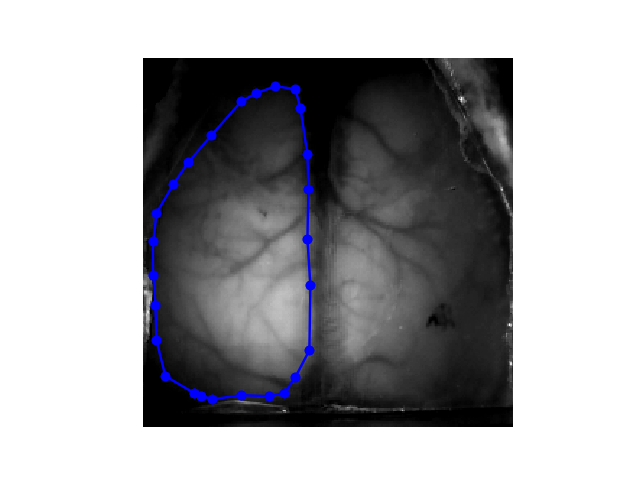

In [100]:
plt.figure()
plt.imshow(left_green_frame, cmap='gray', vmin=0, vmax=150)
plt.xticks([])
plt.yticks([])
LM_left_hem = roipoly(roicolor='b')

<IPython.core.display.Javascript object>


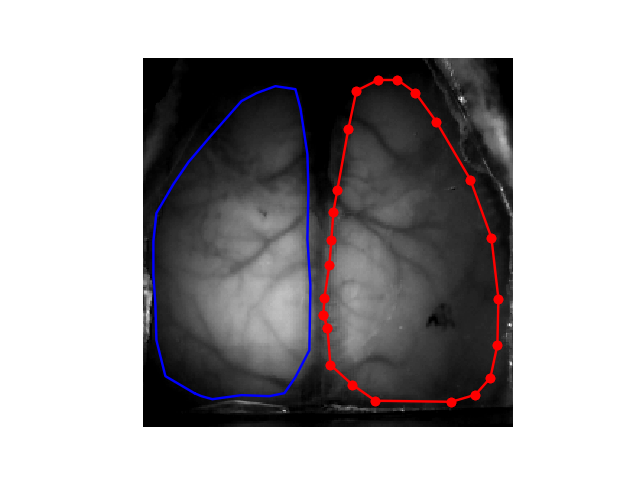

In [102]:
plt.figure()
plt.imshow(left_green_frame, cmap='gray', vmin=0, vmax=150)
LM_left_hem.displayROI()
plt.xticks([])
plt.yticks([])
LM_right_hem = roipoly(roicolor='r')

<IPython.core.display.Javascript object>


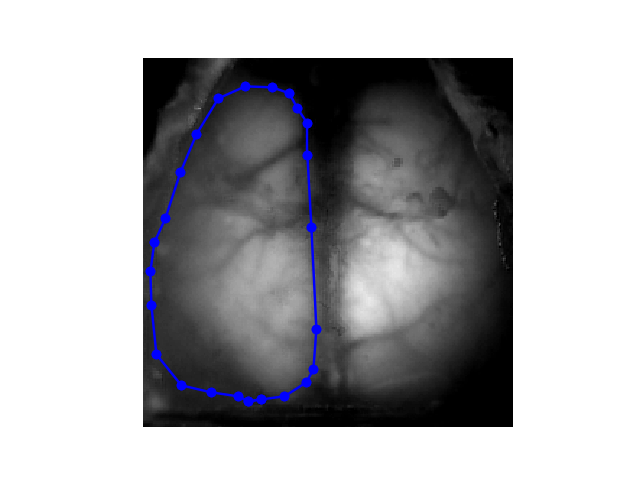

In [103]:
plt.figure()
plt.imshow(right_green_frame, cmap='gray', vmin=0, vmax=150)
plt.xticks([])
plt.yticks([])
RM_left_hem = roipoly(roicolor='b')

<IPython.core.display.Javascript object>


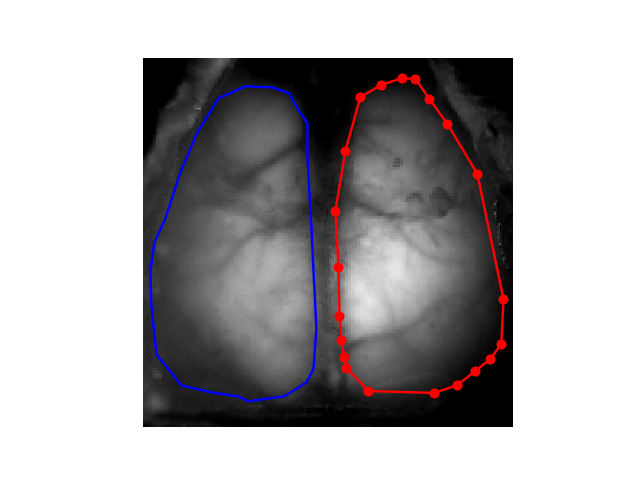

In [104]:
plt.figure()
plt.imshow(right_green_frame, cmap='gray', vmin=0, vmax=150)
RM_left_hem.displayROI()
plt.xticks([])
plt.yticks([])
RM_right_hem = roipoly(roicolor='r')

<IPython.core.display.Javascript object>


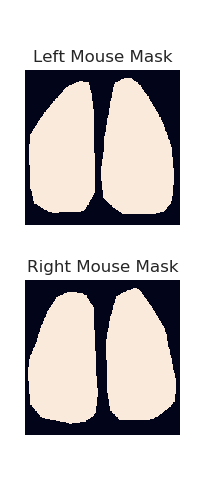

In [105]:
plt.figure(figsize=(2, 5))

left_mouse_mask = np.logical_or(LM_left_hem.getMask(left_mouse_frames[2000]), LM_right_hem.getMask(left_mouse_frames[2000]))
right_mouse_mask = np.logical_or(RM_left_hem.getMask(right_mouse_frames[2000]), RM_right_hem.getMask(right_mouse_frames[2000]))
plt.subplot(2, 1, 1)
plt.title("Left Mouse Mask")
plt.imshow(left_mouse_mask)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.title("Right Mouse Mask")
plt.xticks([])
plt.yticks([])
plt.imshow(right_mouse_mask)

In [106]:
np.save(directory+experiment+"LM_mask_256.npy", left_mouse_mask)
np.save(directory+experiment+"RM_mask_256.npy", right_mouse_mask)


<IPython.core.display.Javascript object>


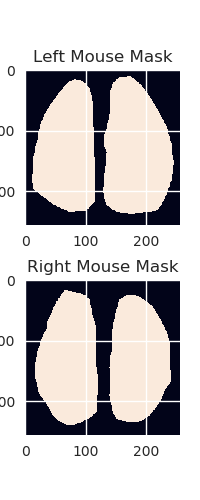

In [88]:
#all_masks = np.load(directory+experiment+"all_maps.npy")
left_mouse_mask = np.load(directory+experiment+"LM_mask_256.npy")
right_mouse_mask = np.load(directory+experiment+"RM_mask_256.npy")
plt.figure(figsize=(2, 5))
plt.subplot(2, 1, 1)
plt.title("Left Mouse Mask")
plt.imshow(left_mouse_mask)
plt.subplot(2, 1, 2)
plt.title("Right Mouse Mask")
plt.imshow(right_mouse_mask)

<IPython.core.display.Javascript object>


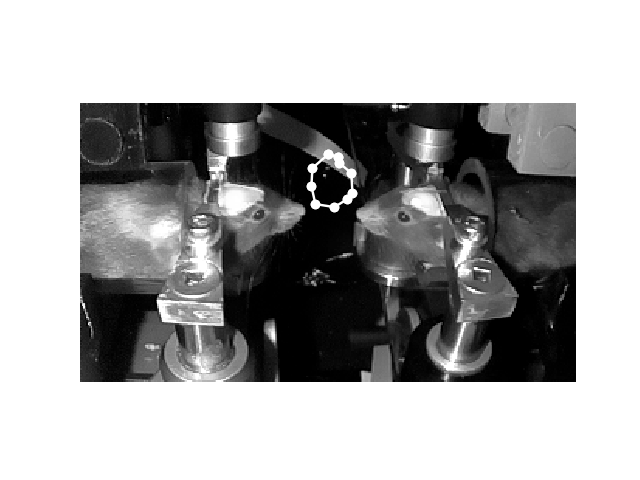

In [109]:
plt.figure()
plt.imshow(behaviour_frames[5000], cmap='gray', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
grad_roi = roipoly(roicolor='w')

In [ ]:
plt.figure()
plt.title("The ROI to subtract")
plt.imshow(behaviour_frames[3217], cmap='gray', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
subtract_grad_roi = roipoly(roicolor='w')

<IPython.core.display.Javascript object>


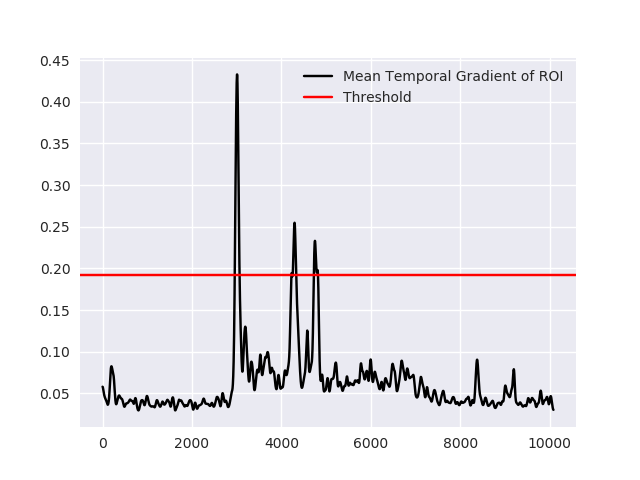

In [110]:
SIGMA=3
MIN_FRAME_THRESHOLD = 100
grad_mask = grad_roi.getMask(behaviour_frames[0])
roi_gradient_signal = gaussian_filter(np.abs(np.gradient(np.mean(behaviour_frames[:, grad_mask], axis=1))),20)
signal_std = np.std(roi_gradient_signal)
signal_mean = np.mean(roi_gradient_signal)

plt.figure()
plt.plot(roi_gradient_signal, color='k', label='Mean Temporal Gradient of ROI')
plt.axhline(signal_mean+SIGMA*signal_std, color='r', label='Threshold')
plt.legend()
indeces = np.where(roi_gradient_signal[:]>= signal_mean+SIGMA*signal_std)
indeces = (indeces[0][np.where(indeces[0] > MIN_FRAME_THRESHOLD)],)
not_indeces = np.where(roi_gradient_signal[:]< signal_mean+SIGMA*signal_std)
not_indeces = (not_indeces[0][np.where(not_indeces[0] > MIN_FRAME_THRESHOLD)],)

In [92]:
print(indeces)


(array([2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966,
       2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977,
       2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988,
       2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999,
       3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010,
       3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021,
       3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032,
       3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043,
       3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054,
       3055, 3056, 3057, 3058, 3059, 3060, 3061, 4257, 4258, 4259, 4260,
       4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271,
       4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282,
       4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293,
       4294, 4295, 4296, 4297, 4298, 4299, 4300, 4

In [ ]:
#indeces = np.random.choice(left_mouse_frames.shape[0], 20)

In [111]:
left_gtm = np.mean(left_mouse_frames[indeces], axis=0)
right_gtm = np.mean(right_mouse_frames[indeces], axis=0)

NOT_left_gtm = np.mean(left_mouse_frames[not_indeces], axis=0)
NOT_right_gtm = np.mean(right_mouse_frames[not_indeces], axis=0)

#left_gtm = left_gtm-NOT_left_gtm
#right_gtm = right_gtm-NOT_right_gtm

left_gtm[~left_mouse_mask] = -100
right_gtm[~right_mouse_mask] = -100



<IPython.core.display.Javascript object>


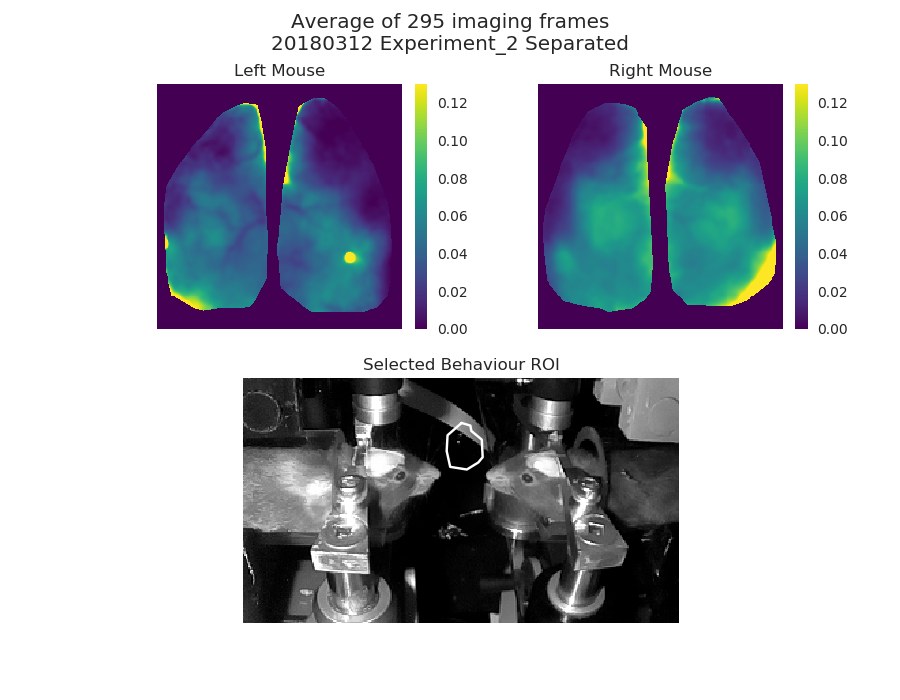

In [112]:

plt.figure(figsize=(9, 7))
#plt.figure(figsize=(8, 4))
plt.suptitle("Average of %s imaging frames\n"%str(np.shape(indeces)[1])+date+" "+experiment[:-1] + " Separated")
plt.subplot(221)
plt.title("Left Mouse")
plt.imshow(left_gtm, cmap='viridis', vmin=0.00, vmax=0.13)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.title("Right Mouse")
plt.imshow(right_gtm, cmap='viridis', vmin=0.00, vmax=0.13)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(212)
plt.title("Selected Behaviour ROI")
plt.imshow(behaviour_frames[3217], cmap='gray', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
grad_roi.displayROI()

plt.savefig(directory+experiment+"whisker_triggered_map.svg")

<IPython.core.display.Javascript object>


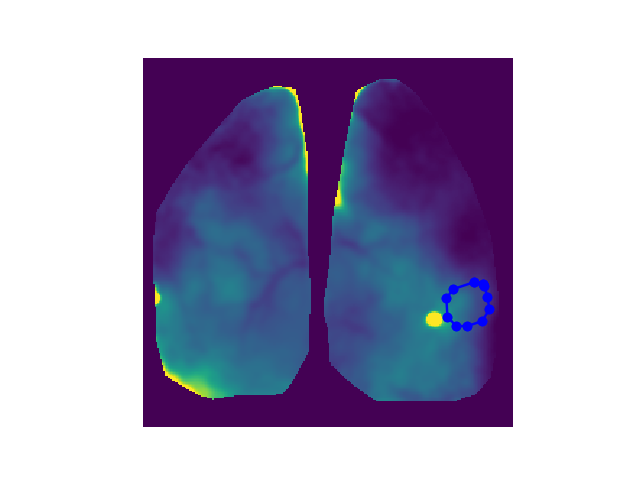

In [113]:
plt.figure()
plt.imshow(left_gtm, cmap='viridis', vmin=0.0, vmax=0.15)
plt.xticks([])
plt.yticks([])
left_gtm_roi = roipoly(roicolor='b')

<IPython.core.display.Javascript object>


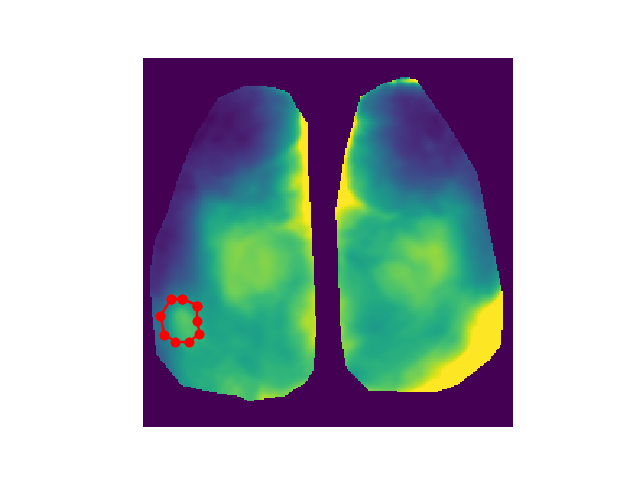

In [114]:
plt.figure()
plt.imshow(right_gtm, cmap='viridis', vmin=0.0, vmax=0.1)
plt.xticks([])
plt.yticks([])
right_gtm_roi = roipoly(roicolor='r')

In [115]:
left_calcium_signal = np.mean(left_mouse_frames[:, left_gtm_roi.getMask(left_mouse_frames[0])], axis=1)
right_calcium_signal = np.mean(right_mouse_frames[:, right_gtm_roi.getMask(right_mouse_frames[0])], axis=1)

exp_duration = left_calcium_signal.shape[0]/IMAGING_FRAMERATE
signal_x_axis =  np.linspace(0, exp_duration, left_calcium_signal.shape[0])

<IPython.core.display.Javascript object>


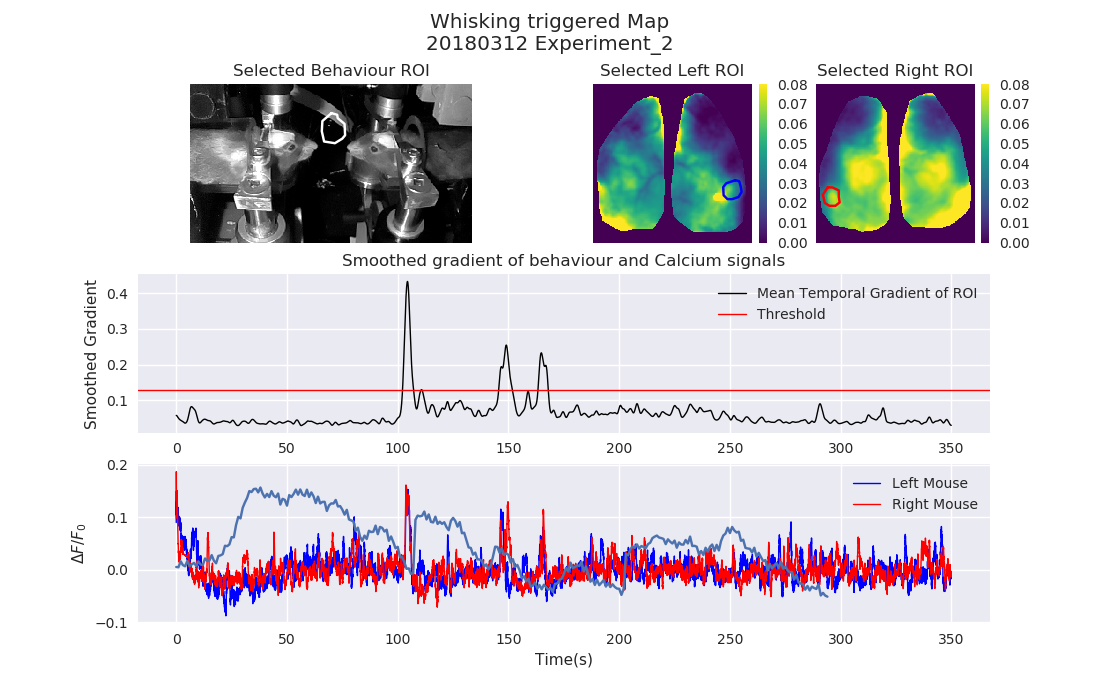

In [116]:
plt.figure(figsize=(11,7))
plt.suptitle("Whisking triggered Map\n"+date+" "+experiment[:-1])


plt.subplot(321)
plt.title("Selected Behaviour ROI")
plt.imshow(behaviour_frames[3217], cmap='gray', vmin=0.0, vmax=255)
plt.xticks([])
plt.yticks([])
grad_roi.displayROI()

plt.subplot(343)
plt.title("Selected Left ROI")
plt.imshow(left_gtm, vmin=0.0, vmax=0.08, cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])
left_gtm_roi.displayROI()

plt.subplot(344)
plt.title("Selected Right ROI")
plt.imshow(right_gtm, vmin=0.0, vmax=0.08, cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])
right_gtm_roi.displayROI()


plt.subplot(312)
plt.title("Smoothed gradient of behaviour and Calcium signals")
plt.plot(signal_x_axis, roi_gradient_signal, color='k', linewidth=1, label='Mean Temporal Gradient of ROI')
plt.ylabel("Smoothed Gradient")
#plt.xticks([])
plt.axhline(SIGMA*signal_std, color='r', linewidth=1, label='Threshold')
plt.legend()

plt.subplot(313)
plt.plot(signal_x_axis, left_calcium_signal, linewidth=1, color='b', label='Left Mouse')
plt.plot(signal_x_axis, right_calcium_signal, linewidth=1, color='r', label='Right Mouse')
plt.ylabel("$\Delta F/F_0$")
plt.xlabel("Time(s)")

plt.legend()
plt.savefig(directory+experiment+"whisker_triggered_map_with_signals.svg")

In [126]:
percentile_75 = np.array([np.percentile(left_calcium_signal[indeces], 75), \
                         np.percentile(right_calcium_signal[indeces], 75)])

if '12mm' in left_green_frame_file:
    np.save(directory+experiment+"75th_percentile_calcium_together.npy", percentile_75)
    print("rofl")

# Make Video of the behaviour frames that were selected

<IPython.core.display.Javascript object>


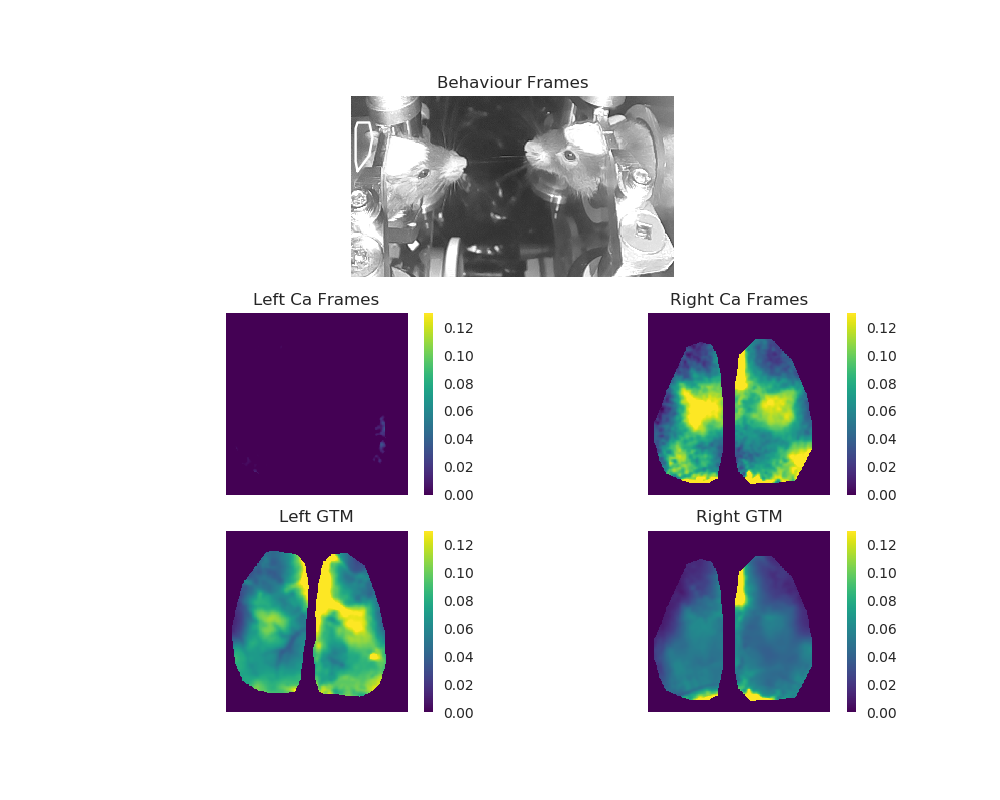

Writing frames...
Done!


In [103]:
im_frame = np.zeros((256, 256))
beh_frame = np.zeros((180, 320))

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='10Hz_playback')
writer = FFMpegWriter(fps=10, metadata=metadata)
fig = plt.figure(figsize=(10, 8))
#sns.set_style('white')
ax3 = fig.add_subplot(3, 1, 1)
ax3.set_title("Behaviour Frames")
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
beh_frame = behaviour_frames[indeces[0][0]]
beh_image = ax3.imshow(beh_frame, cmap='gray', vmin=0, vmax=255)
grad_roi.displayROI()


ax1 = fig.add_subplot(3, 2, 3)
ax1.set_title("Left Ca Frames")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
im_frame =  left_gtm
im_LM_ca = ax1.imshow(im_frame, cmap='viridis', vmin=0, vmax=0.13)
cbar = fig.colorbar(im_LM_ca)

ax2 = fig.add_subplot(3, 2, 4)
ax2.set_title("Right Ca Frames")
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
im_frame =  right_gtm
im_RM_ca = ax2.imshow(im_frame, cmap='viridis', vmin=0, vmax=0.13)
cbar = fig.colorbar(im_RM_ca)


ax4 = fig.add_subplot(3, 2, 5)
ax4.set_title("Left GTM")
ax4.get_yaxis().set_visible(False)
ax4.get_xaxis().set_visible(False)
im_frame =  left_gtm
im_left_gtm = ax4.imshow(im_frame, cmap='viridis', vmin=0, vmax=0.13)
cbar = fig.colorbar(im_left_gtm)

ax5 = fig.add_subplot(3, 2, 6)
ax5.set_title("Right GTM")
ax5.get_yaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)
im_frame =  right_gtm
im_right_gtm = ax5.imshow(im_frame, cmap='viridis', vmin=0, vmax=0.13)
cbar = fig.colorbar(im_right_gtm)


print("Writing frames...")
with writer.saving(fig, directory+experiment+left_mouse_processed_file.split('/')[-1]+"_behaviour_frames_GTM_LM_body.mp4", 100):
    for i in indeces[0]:
        # Set title
        
        #ax1.set_title("Seed Map %s/%s" %(str(i), str(full_distance_array.shape[0])))
        beh_frame = behaviour_frames[i]
        beh_image.set_data(beh_frame)
        im_frame = left_mouse_frames[i]
        im_frame[~left_mouse_mask] = -100
        im_LM_ca.set_data(im_frame)
        im_frame = right_mouse_frames[i]
        im_frame[~right_mouse_mask] = -100
        im_RM_ca.set_data(im_frame)
        #print(i//window_size)
        #print(combined_frames.shape[0]//(i*cluster_maps.shape[0])
        #int((combined_frames.shape[0]-window_size)/window_shift)+1
        writer.grab_frame()

print("Done!")

In [ ]:
SIGMA=2
grad_mask = grad_roi.getMask(behaviour_frames[0])
roi_gradient_signal = gaussian_filter(np.abs(np.gradient(np.mean(behaviour_frames[:, grad_mask], axis=1))),20)
signal_std = np.std(roi_gradient_signal)
signal_mean = np.mean(roi_gradient_signal)

subtract_grad_mask = subtract_grad_roi.getMask(behaviour_frames[0])
subtract_roi_gradient_signal = gaussian_filter(np.abs(np.gradient(np.mean(behaviour_frames[:, subtract_grad_mask], axis=1))),20)
subtract_signal_std = np.std(subtract_roi_gradient_signal)
subtract_signal_mean = np.mean(subtract_roi_gradient_signal)

plt.figure()
plt.subplot(211)
plt.plot(roi_gradient_signal, color='k', label='Mean Temporal Gradient of ROI')
plt.axhline(signal_mean+SIGMA*signal_std, color='r', label='Threshold')
plt.legend()
plt.subplot(212)
plt.plot(subtract_roi_gradient_signal, color='k', label='Mean Temporal Gradient of ROI')
plt.axhline(subtract_signal_mean+SIGMA*subtract_signal_std, color='r', label='Threshold')
plt.legend()
indeces = np.where(roi_gradient_signal[100:]>= signal_mean+SIGMA*signal_std)
indeces = np.asarray(indeces)
indeces += 100
subtract_indeces = np.where(subtract_roi_gradient_signal[100:]>=subtract_signal_mean+SIGMA*subtract_signal_std)
subtract_indeces = np.asarray(subtract_indeces)
subtract_indeces+=100
# not_indeces = np.where(roi_gradient_signal[30:]< signal_mean+SIGMA*signal_std)

In [ ]:
print(np.shape(indeces))

In [ ]:
pruned_indeces = [[]]
for index in indeces[0]:
    add = True
    for subtract_index in subtract_indeces[0]:
        if index == subtract_index:
            add = False
    if add:
        pruned_indeces[0].append(index)
print(pruned_indeces)

In [ ]:
left_gtm = np.mean(left_mouse_frames[pruned_indeces], axis=0)
right_gtm = np.mean(right_mouse_frames[pruned_indeces], axis=0)


left_gtm[~left_mouse_mask] = -100
right_gtm[~right_mouse_mask] = -100



In [ ]:
plt.figure(figsize=(9, 7))
#plt.figure(figsize=(8, 4))
plt.suptitle("Average of %s imaging frames\n"%str(np.shape(pruned_indeces)[1])+date+" "+experiment[:-1] + " Separated")
plt.subplot(221)
plt.title("Left Mouse")
plt.imshow(left_gtm, cmap='viridis', vmin=0.00, vmax=0.07)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.title("Right Mouse")
plt.imshow(right_gtm, cmap='viridis', vmin=0.00, vmax=0.15)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(212)
plt.title("Selected Behaviour ROI")
plt.imshow(behaviour_frames[3217], cmap='gray', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
grad_roi.displayROI()

plt.savefig(directory+experiment+"whisker_triggered_map.svg")